In [41]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon, LineString
from sklearn.neighbors import KernelDensity

place_one = GoalPolygon('Жилой комплекс «Одинцово-1»')
v = place_one.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

In [42]:
'''def get_xy(s):

    x, y = s.centroid.coords.xy
    return x[0], y[0]'''

'def get_xy(s):\n\n    x, y = s.centroid.coords.xy\n    return x[0], y[0]'

Здесь полигон в нуле не от центра

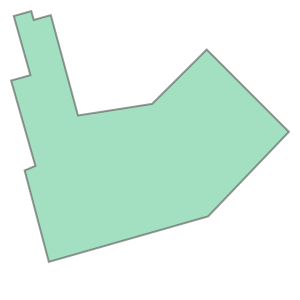

In [43]:
from shapely.affinity import translate
import numpy as np

s = v.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)
st

In [44]:
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))
coor_list

[(0.0, 679.7554941019043),
 (90.92466560343746, 359.8743795603514),
 (50.64634319592733, 342.689586349763),
 (141.4154383126297, 0.0),
 (738.6390963118174, 170.50443049520254),
 (1041.5171545767225, 487.5379093941301),
 (733.3747470285161, 795.9299552580342),
 (528.746321437764, 592.3512355554849),
 (250.68498866126174, 548.8781394008547),
 (148.7872773281997, 925.0354834403843),
 (84.8542414731346, 907.106489722617),
 (75.55369137861999, 940.1296991426498),
 (9.845574646664318, 921.7006750889122),
 (72.29789360892028, 700.0236357413232)]

разбиение точек на группы по сегментам

In [45]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) *2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    print (cr)
    cross = [*cr, cr[0] + cr[-1] + 1]
    print(cross)
    double_points = [*range(len(point_list)), *range(len(point_list))]
    points = [*point_list, *point_list]
    segments = [double_points[cross[c]:cross[c + 1]] for c in range(len(cross) - 1)]
    lines = [LineString(points[cross[c]:cross[c + 1]+1]) for c in range(len(cross) - 1)]
    return segments, lines


In [46]:
bb, ll = vec_search(coor_list, 0.7)
bb

[1, 4, 7, 8, 10, 13]
[1, 4, 7, 8, 10, 13, 15]


[[1, 2, 3], [4, 5, 6], [7], [8, 9], [10, 11, 12], [13, 0]]

In [47]:
def chains_base (point_list, parts):
    vectors =[]
    for i in parts:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

In [48]:
res_vec = chains_base(coor_list, bb)
res_vec

[[[40.27832240751013, 17.184793210588396],
  [-90.76909511670237, 342.689586349763]],
 [[-302.8780582649051, -317.03347889892757],
  [308.1424075482064, -308.39204586390406]],
 [],
 [[101.89771133306203, -376.15734403952956]],
 [[9.30055009451462, -33.0232094200328],
  [65.70811673195567, 18.42902405373752]],
 [[72.29789360892028, 20.2681416394189]]]

Tests of clusterized x or y

In [49]:
#res_vec = chains_base(coor_list, bb)
#res_vec = [[[ -17.18479321 ,  40.27832241],[ -90.76909512 , 342.68958635],[-170.5044305 ,  597.223658  ]],[[ 302.87805826 , 317.0334789 ], [-308.14240755 , 308.39204586], [-203.5787197 ,  204.62842559]],[[ -43.47309615 , 278.06133278]],[[-101.89771133,  376.15734404],[ -17.92899372,   63.93303586]],[[  -9.30055009,   33.02320942], [ -18.42902405 ,  65.70811673],[ -62.45231896 , 221.67703935]],[[ -20.26814164 ,  72.29789361],[ -90.9246656  , 319.88111454]]]

In [68]:
res_vec = [[[40.27832240751013, 17.184793210588396], [342.689586349763, 90.76909511670239], [597.2236579991877, 170.50443049520254]], [[317.03347889892757, -302.8780582649051], [308.39204586390406, 308.1424075482064], [204.62842559075216, 203.57871970254928]], [[278.06133277650224, 43.473096154630184]], [[376.15734403952956, 101.89771133306206], [63.9330358550651, 17.928993717767298]], [[33.0232094200328, 9.300550094514621], [65.70811673195567, 18.42902405373752], [221.67703934758902, 62.45231896225597]], [[72.29789360892028, 20.2681416394189], [319.88111454155296, 90.92466560343748]]]


Test of merged vecs

In [69]:
all_vec = [[40.27832240751013, 17.184793210588396], [342.689586349763, 90.76909511670239], [597.2236579991877, 170.50443049520254], [317.03347889892757, -302.8780582649051], [308.39204586390406, 308.1424075482064], [204.62842559075216, 203.57871970254928], [278.06133277650224, 43.473096154630184], [376.15734403952956, 101.89771133306206], [63.9330358550651, 17.928993717767298], [33.0232094200328, 9.300550094514621], [65.70811673195567, 18.42902405373752], [221.67703934758902, 62.45231896225597], [72.29789360892028, 20.2681416394189], [319.88111454155296, 90.92466560343748]]

SVD

In [77]:
from scipy.linalg import svd
import numpy as np
import torch

#A = np.asarray(res_vec)
#B = np.asarray(all_vec)

In [78]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        #self.A = m
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        #U, S, Vh = svd(self.A, **kwargs)
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        #Sigma = np.diag(S)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))

In [79]:
pck = SvdPack()
pck_all = SvdPack()

In [80]:
a_=np.asarray(res_vec, dtype=object)
pck.matrices = a_

b_=np.asarray(all_vec)
pck_all.matrices = b_
a_

tensor([[-0.0606,  0.6910, -0.7203],
        [-0.4948, -0.6476, -0.5795],
        [-0.8669,  0.3213,  0.3811]]) tensor([716.4312,   8.1783]) tensor([[-0.9627, -0.2705],
        [-0.2705,  0.9627]]) tensor([[716.4312,   0.0000],
        [  0.0000,   8.1783]])
set item id: 0:0:0
tensor([[-0.0671,  0.9977, -0.0012],
        [-0.8319, -0.0566, -0.5520],
        [-0.5509, -0.0360,  0.8338]]) tensor([523.2039, 438.0382]) tensor([[-0.7464, -0.6655],
        [ 0.6655, -0.7464]]) tensor([[523.2039,   0.0000],
        [  0.0000, 438.0382]])
set item id: 0:0:1
tensor([[-1.]]) tensor([281.4392]) tensor([[-0.9880, -0.1545],
        [-0.1545,  0.9880]]) tensor([[281.4392]])
set item id: 0:0:2
tensor([[-0.9858, -0.1680],
        [-0.1680,  0.9858]]) tensor([395.3303,   0.5805]) tensor([[-0.9651, -0.2617],
        [-0.2617,  0.9651]]) tensor([[395.3303,   0.0000],
        [  0.0000,   0.5805]])
set item id: 0:0:3
tensor([[-0.1414,  0.0047, -0.9899],
        [-0.2813, -0.9590,  0.0356],
        [-0.949

array([list([[40.27832240751013, 17.184793210588396], [342.689586349763, 90.76909511670239], [597.2236579991877, 170.50443049520254]]),
       list([[317.03347889892757, -302.8780582649051], [308.39204586390406, 308.1424075482064], [204.62842559075216, 203.57871970254928]]),
       list([[278.06133277650224, 43.473096154630184]]),
       list([[376.15734403952956, 101.89771133306206], [63.9330358550651, 17.928993717767298]]),
       list([[33.0232094200328, 9.300550094514621], [65.70811673195567, 18.42902405373752], [221.67703934758902, 62.45231896225597]]),
       list([[72.29789360892028, 20.2681416394189], [319.88111454155296, 90.92466560343748]])],
      dtype=object)

In [81]:
pck_vh = pck.Vh
pckall_vh = pck_all.Vh

pck_vh

[tensor([[-0.9627, -0.2705],
         [-0.2705,  0.9627]]),
 tensor([[-0.7464, -0.6655],
         [ 0.6655, -0.7464]]),
 tensor([[-0.9880, -0.1545],
         [-0.1545,  0.9880]]),
 tensor([[-0.9651, -0.2617],
         [-0.2617,  0.9651]]),
 tensor([[-0.9626, -0.2711],
         [-0.2711,  0.9626]]),
 tensor([[-0.9619, -0.2732],
         [-0.2732,  0.9619]])]

Работа с транспортированными точками

In [75]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]<0 and i[1][0]>0 or i[0][1]>0 and i[1][0]<0 :
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked

identical_matricies = matricies_check(pck_vh)
identical_matricies

[tensor([[-0.9627, -0.2705],
         [ 0.2705, -0.9627]]),
 tensor([[-0.7464, -0.6655],
         [ 0.6655, -0.7464]]),
 tensor([[-0.9880, -0.1545],
         [ 0.1545, -0.9880]]),
 tensor([[-0.9651, -0.2617],
         [ 0.2617, -0.9651]]),
 tensor([[-0.9626, -0.2711],
         [ 0.2711, -0.9626]]),
 tensor([[-0.9619, -0.2732],
         [ 0.2732, -0.9619]])]

In [82]:
def transform_chains_from_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_from_vh(bb, pck_vh)
ptt = [(pckall_vh[0] @ np.asarray(i)).tolist() for i in coor_list]
print (ptt)

[[-198.54299384118383, -650.1139987404546], [-192.07190790968014, -317.6243788990073], [-148.53063197695704, -312.95344068442046], [-135.2488606311659, 41.30462312047695], [-756.230852245163, 52.67232225169358], [-1138.5007182373984, -162.07193139751223], [-933.8703564426389, -547.0184371791274], [-678.7037060604588, -412.0848675671983], [-400.06992486718156, -451.7236219958049], [-412.48361881586754, -841.240491017337], [-346.1017534655098, -842.7668730087632], [-346.8521836665056, -877.0665734006523], [-278.6265929505532, -878.6331950821381], [-273.60817636348213, -648.3815557554343]]


In [59]:
def chains_tovec (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors


#transformed chains
v_t = chains_tovec(p_t)
# merged vec
v_ = chains_base(ptt,bb)
v_



[[[-43.541275932723096, -4.67093821458684],
  [-13.281771345791128, -354.2580638048974]],
 [[382.2698659922354, 214.7442536492058],
  [-204.63036179475944, 384.9465057816152]],
 [],
 [[12.413693948685989, 389.51686902153216]],
 [[0.7504302009958224, 34.29970039188902],
  [-68.22559071595242, 1.566621681485799]],
 [[-75.0651825222983, 1.7324429850202705]]]

In [60]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle (v_tr, v_b):
    ang =[]
    for j, i in enumerate(v_tr):
        for ind, val in enumerate(i):
            ang.append(angle_between(val, v_b[j][ind]))
            break
    return ang

angl = angle(v_t, v_)
angl

[1.5482619460375535,
 2.002516249114573,
 1.53918785429961,
 1.5489105845327773,
 1.5511609618942102]

In [61]:
def  clusterize(angles, eps=0.2):
    points_sorted = sorted(angles)
    curr_point = points_sorted[0]
    curr_cluster = 0
    angles[angles.index(points_sorted[0])] = 0
    for point in points_sorted[1:]:
        if point <= curr_point + eps:
            angles[angles.index(point)] = curr_cluster
        else:
            curr_cluster+=1
            angles[angles.index(point)] = curr_cluster
        curr_point = point
    return angles


labels = clusterize(angl)
labels

[0, 1, 0, 0, 0]

In [62]:
#OLD
'''scope = np.asarray(angl)/np.linalg.norm(angl)
r = np.round(scope*len(angl),0)
labels=[]
l = np.unique(r).tolist()
for i in r:
    labels.append(l.index(i))
print(labels)'''


'scope = np.asarray(angl)/np.linalg.norm(angl)\nr = np.round(scope*len(angl),0)\nlabels=[]\nl = np.unique(r).tolist()\nfor i in r:\n    labels.append(l.index(i))\nprint(labels)'

Display

In [63]:
from collections import defaultdict

d_ = defaultdict(list)
for la, l in zip(labels, ll):
    d_[la].append(l)

print(d_)

defaultdict(<class 'list'>, {0: [<shapely.geometry.linestring.LineString object at 0x7f9a74f2a440>, <shapely.geometry.linestring.LineString object at 0x7f9a74f2af20>, <shapely.geometry.linestring.LineString object at 0x7f9a74f2acb0>, <shapely.geometry.linestring.LineString object at 0x7f9a74f28a30>], 1: [<shapely.geometry.linestring.LineString object at 0x7f9a74f28160>]})


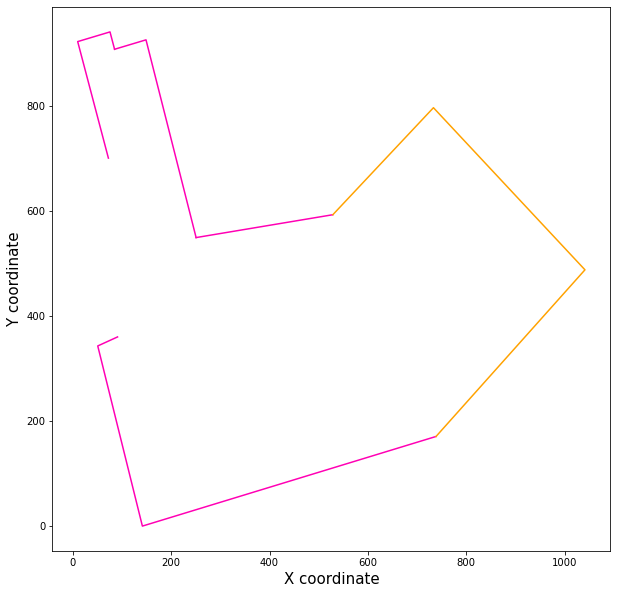

In [64]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
for d in d_[0]:
    ax.plot(*d.xy, label='LineString', color='#ff00b4')
for d in d_[1]:
    ax.plot(*d.xy, label='LineString', color='#ffa200')
for d in d_[2]:
    ax.plot(*d.xy, label='LineString', color='#ff0000')
for d in d_[3]:
    ax.plot(*d.xy, label='LineString', color='#00ff54')
for d in d_[4]:
    ax.plot(*d.xy, label='LineString', color='#0012ff')
for d in d_[5]:
    ax.plot(*d.xy, label='LineString', color='#ffcc00')
for d in d_[6]:
    ax.plot(*d.xy, label='LineString', color='#9c00ff')

plt.show()